In [1]:
import numpy as np  # Resolver operaciones de algebra lineal
import pandas as pd  # Procesamiento de datos, archivos CSV
from matplotlib import pyplot as plt

teams = pd.read_csv('/Users/Administrador/Desktop/EuroData/jugadores.csv', sep=";")

rankings = pd.read_csv('/Users/Administrador/Desktop/EuroData/fifa_ranking.csv')
rankings = rankings.replace({'FYR Macedonia': 'North Macedonia'})
rankings = rankings.loc[:, ['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date',
                           'two_year_ago_weighted', 'three_year_ago_weighted']]

rankings['weighted_points'] = rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted']  + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('/Users/Administrador/Desktop/EuroData/results.csv')
matches = matches.replace({'German DR': 'Germany'})
matches['date'] = pd.to_datetime(matches['date'])

euro_cup = pd.read_csv('/Users/Administrador/Desktop/EuroData/grupos_euro.csv', sep=";")
euro_cup = euro_cup[['Team', 'Group', 'First match against', 'Second match against', 'Third match against']]
euro_cup = euro_cup.dropna(how='all')

In [2]:
# Unimos rankings
matches = matches.merge(rankings,
                        left_on=['date', 'home_team'],
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings,
                        left_on=['date', 'away_team'],
                        right_on=['rank_date', 'country_full'],
                        suffixes=('_home', '_away'))

# Agregamos el potencial del equipo al dataset de partidos
teamValue = teams.groupby('squad').mean()['overall']
matches = matches.merge(teamValue, 
                        left_on=['home_team'], 
                        right_on=['squad'])
matches = matches.merge(teamValue, 
                        left_on=['away_team'], 
                        right_on=['squad'], 
                        suffixes=('_home', '_away'))

# Agregar diferencia de potencial entre los equipos
matches['teamValue_difference'] = matches['overall_home'] - matches['overall_away']

# Agregando el potencial del equipo al dataset de copa
euro_cup = euro_cup.merge(teamValue, 
                        left_on=['Team'], 
                        right_on=['squad'])
euro_cup = euro_cup.set_index('Team')

In [3]:
# Generamos caracteristicas
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0  # Tomamos el empate como derrota
matches['is_stake'] = matches['tournament'] != 'Friendly'

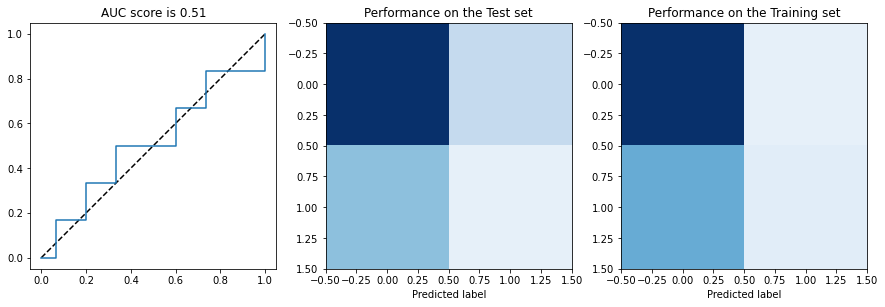

In [4]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:, ['average_rank', 'rank_difference', 'teamValue_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# Graficos
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 3, 1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])))
ax.set_aspect(1)

ax = plt.subplot(1, 3, 2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim=(0, cm.max()))

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1, 3, 3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim=(0, cm.max()))
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

In [5]:
euro_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) &
                                    rankings['country_full'].isin(euro_cup.index.unique())]
euro_cup_rankings = euro_cup_rankings.set_index(['country_full'])

In [6]:
import progressbar

simulation_results = list()
n_simulations = 1000
bar = progressbar.ProgressBar(max_value=n_simulations)

for i in range(n_simulations):
    bar.update(i)
    candidates = ['Belgium', 'Portugal', 'Switzerland', 'Czech Republic',
                  'Germany', 'Wales', 'Austria', 'Sweden',
                  'Spain', 'Croatia', 'Netherlands', 'France',
                  'England', 'Ukraine', 'Italy', 'Denmark']
    finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

    for f in finals:
        iterations = int(len(candidates) / 2)
        winners = []

        for i in range(iterations):
            home = candidates[i * 2]
            away = candidates[i * 2 + 1]

            row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
            home_rank = euro_cup_rankings.loc[home, 'rank']
            home_points = euro_cup_rankings.loc[home, 'weighted_points']
            opp_rank = euro_cup_rankings.loc[away, 'rank']
            opp_points = euro_cup_rankings.loc[away, 'weighted_points']
            teamValue_home = euro_cup.loc[home, 'overall']
            teamValue_away = euro_cup.loc[away, 'overall']
            
            row['average_rank'] = (home_rank + opp_rank) / 2
            row['rank_difference'] = home_rank - opp_rank
            #row['point_difference'] = home_points - opp_points
            row['teamValue_difference'] = teamValue_home - teamValue_away

            home_win_prob = model.predict_proba(row)[:, 1][0]

            # simulation step based on the probability
            simulated_outcome = np.random.binomial(1, home_win_prob)
            winners.append(away) if simulated_outcome <= 0.5 else winners.append(home)
        candidates = winners
    simulations_results = simulation_results.append(candidates)

simulation_results = sum(simulation_results, [])

 99% (997 of 1000) |#################### | Elapsed Time: 0:00:41 ETA:   0:00:00

Text(0, 0.5, 'Winning probability')

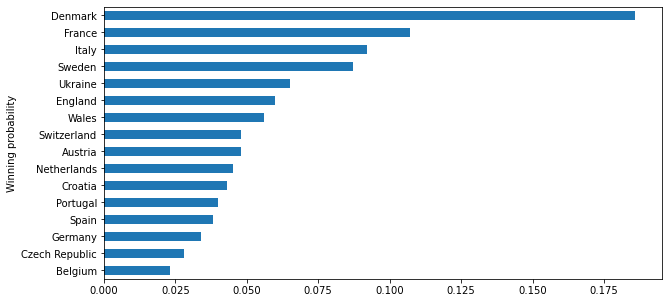

In [7]:
pd.Series(simulation_results).value_counts().sort_values().divide(n_simulations).plot.barh(figsize=(10,5))
plt.ylabel('Winning probability')